In [4]:
import os, sys

import pandas as pd
import numpy as np
from tqdm import tqdm

import src.inference as inf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, r2_score
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [5]:
device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"

In [6]:
VALIDATION = True
directory = 'checkpoint/msn-complete-br-data' 
config_file = "params-temperature-exp-2-c30.yaml"
read_path="results/temperature"

params, dataset = inf.read_data(directory,config_file,validation=VALIDATION)
target_encoder, prot = inf.load_model(params)

E, F = inf.get_model_results(read_path)
E_val, F_val = inf.get_model_results(read_path, validation=True)

INFO:root:data loader created
Loaded E and F from results/temperature
Loaded E and F from results/temperature


In [7]:
cluster_prob, cluster_id = torch.max(F, dim=1) 
df = pd.DataFrame({"cluster_id": cluster_id.cpu(), "cluster_prob": cluster_prob.cpu(),
                   'sample_type':'train','date':dataset.time})

val_cluster_prob, val_cluster_id = torch.max(F_val, dim=1) # Obtém os valores máximos e seus índices
df_val = pd.DataFrame({"cluster_id": val_cluster_id.cpu(),"cluster_prob": val_cluster_prob.cpu(),
                        'sample_type':'val','date':dataset.val_time})
    

df =  pd.concat([df,df_val]).reset_index(drop=True) 
df = df.sort_values('date')
del df_val

In [8]:
# https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-nino-index
oni_index = pd.read_excel('data/oni_index.xlsx')
oni_index.set_index('Year', inplace=True)
oni_index.columns.name='Month'
original_col = list( oni_index.columns)
new_cols = [i for i in range(2,13)]+[1] #ultimo mes da média móvel
oni_index.columns = new_cols
oni_index= oni_index.unstack().to_frame('ONI')

oni_index['date_period'] = pd.to_datetime(oni_index.index.map(lambda x: f"{x[1]}-{x[0]}-01")).to_period('M')
oni_index.set_index('date_period', inplace=True)
df['period']= df['date'].dt.to_period('M')

df = df.merge(oni_index[['ONI']], left_on='period', right_index=True, how='left')
df.head()

,cluster_id,cluster_prob,sample_type,date,period,ONI
0,19,0.885574,train,1961-01-01,1961-01,-0.2
1,27,0.890362,train,1961-01-02,1961-01,-0.2
2,19,0.957950,train,1961-01-03,1961-01,-0.2
3,12,0.972468,train,1961-01-04,1961-01,-0.2
4,19,0.972903,train,1961-01-05,1961-01,-0.2


## Teste 1: 
ONI consegue prever qual cluster vai dominar o mês?

In [9]:
cluster_dist = (
    df.groupby(["period", "cluster_id"])
      .size()
      .unstack(fill_value=0)
)

cluster_dist = cluster_dist.div(cluster_dist.sum(axis=1), axis=0) #normalizar
cluster_dist = cluster_dist.join(oni_index)
cluster_dist

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,ONI
period,,,,,,,,,,,,,,,,,,,,,
1961-01,0.000000,0.000000,0.00000,0.0,0.032258,0.000000,0.064516,0.0,0.0,0.000000,...,0.000000,0.000000,0.129032,0.000000,0.000000,0.032258,0.129032,0.000000,0.000000,-0.2
1961-02,0.000000,0.000000,0.00000,0.0,0.107143,0.000000,0.142857,0.0,0.0,0.000000,...,0.000000,0.000000,0.214286,0.071429,0.000000,0.035714,0.035714,0.000000,0.000000,0.0
1961-03,0.000000,0.096774,0.00000,0.0,0.096774,0.032258,0.193548,0.0,0.0,0.032258,...,0.000000,0.000000,0.096774,0.290323,0.000000,0.064516,0.032258,0.000000,0.000000,0.0
1961-04,0.000000,0.066667,0.00000,0.0,0.000000,0.133333,0.200000,0.0,0.0,0.000000,...,0.000000,0.000000,0.133333,0.133333,0.000000,0.133333,0.000000,0.000000,0.000000,0.0
1961-05,0.000000,0.000000,0.00000,0.0,0.000000,0.064516,0.064516,0.0,0.0,0.258065,...,0.193548,0.000000,0.000000,0.000000,0.032258,0.129032,0.000000,0.064516,0.000000,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11,0.000000,0.066667,0.30000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.566667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,1.8
2023-12,0.096774,0.032258,0.16129,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.516129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129032,1.9
2024-01,0.290323,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.193548,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.354839,-0.5


In [10]:
def get_dataset(window=12, vars=['ONI'],split_ratio=0.8):
    
    X_list, Y_list = [], []

    Y = cluster_dist.drop("ONI",axis=1).values   
    X = cluster_dist[vars].values

    for t in range(window, len(cluster_dist)-1):
        X_list.append(X[t-window:t])     # ONI dos W meses anteriores
        Y_list.append(Y[t])         # distribuição do mês corrente 
        
    X = np.stack(X_list, axis=0)    # [N, W, 1]
    Y = np.stack(Y_list, axis=0)

    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)

    split = int(split_ratio*len(X))
    X_train, Y_train = X[:split], Y[:split]
    X_test,  Y_test  = X[split:], Y[split:]
    
    return X_train, Y_train, X_test, Y_test

In [11]:
class ONI2ClustersGRU(nn.Module):
    def __init__(self, input_size=2, hidden=32, num_layers=1, sequence_length=12,  n_clusters=30):
        super().__init__()
 
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden, num_layers=num_layers, batch_first=True,dropout=0.2)
        # self.fc  =  nn.Sequential(
        #     nn.Linear(hidden*sequence_length, n_clusters)
        # )
        self.fc = nn.Sequential(
            nn.Linear(hidden*sequence_length, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_clusters)
        )
        self.sm  = nn.LogSoftmax(dim=-1)
        
    def forward(self, x):                 # x: [B, W, 1]
        out, _ = self.gru(x)              # [B, W, H]
        logits = self.fc(out.reshape(out.size(0), -1))               # [B, K]
        return self.sm(logits)            # distribuição (soma=1)

/u00/livia.meinhardt/projects/climate-clustering/env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
  5%|▌         | 4/75 [00:00<00:04, 14.70it/s]

100%|██████████| 75/75 [00:03<00:00, 21.90it/s]


Text(0.5, 1.0, 'Training Loss;  Last: 0.5793')

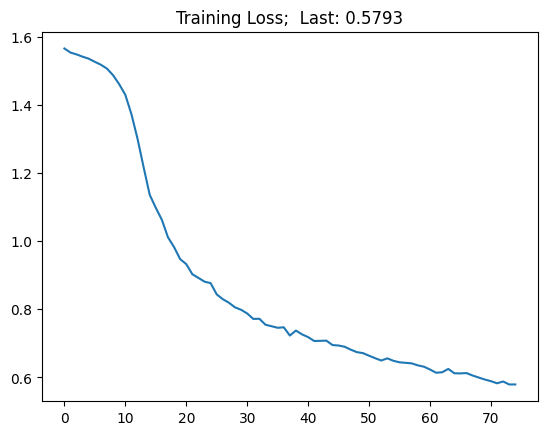

In [12]:
EPOCHS = 75
BS = 32
W=12
X_train, Y_train, X_test, Y_test = get_dataset(window=W, vars=['ONI'], split_ratio=0.9)

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BS, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test,  Y_test),  batch_size=64, shuffle=False)

model = ONI2ClustersGRU(input_size=1,sequence_length=W).to(device)
criterion = nn.KLDivLoss(reduction="batchmean") 
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

model.train()
loss_list = []

for t in tqdm(range(EPOCHS)): 
    cur_epoch_loss = []
    for batch, (xb, yb) in enumerate(train_loader):
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = criterion(pred, yb)

        # Retropropagação
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        cur_epoch_loss.append(loss.item())
        
    loss_list.append(np.average(cur_epoch_loss))

plt.plot(loss_list)
plt.title(f'Training Loss;  Last: {loss_list[-1]:.4f}')

In [13]:
def js_divergence(p, q, eps=1e-20):
    m = 0.5*(p+q)
    kl_pm = (p * (np.log(p+eps)-np.log(m+eps))).sum(axis=-1)
    kl_qm = (q * (np.log(q+eps)-np.log(m+eps))).sum(axis=-1)
    return 0.5*(kl_pm+kl_qm)


model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds.append(model(xb).exp().cpu().numpy())
        trues.append(yb.cpu().numpy())
P = np.vstack(preds)   
Q = np.vstack(trues)   
print("Mean JS divergence:", js_divergence(P, Q).mean())

#Baseline: prever a distribuição média de treino (sem ONI)
baseline = Y_train.mean(axis=0, keepdims=True).numpy()       
B = np.repeat(baseline, len(Q), axis=0)              
print("Baseline JS divergence:", js_divergence(B, Q).mean())

mae_per_cluster = abs(P - Q).mean()*100
print(f"MAE per cluster: {mae_per_cluster:.4f}%")

Mean JS divergence: 0.26554433
Baseline JS divergence: 0.40423635
MAE per cluster: 3.7204%


<Axes: >

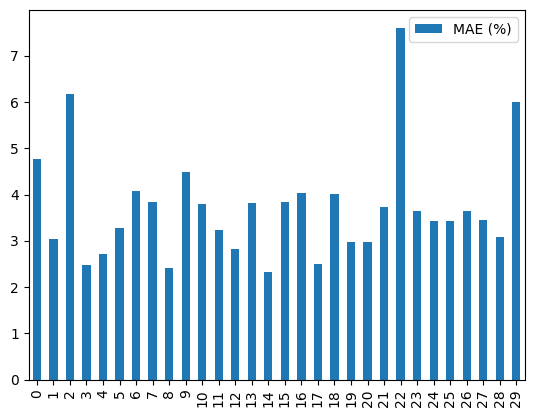

In [14]:
mae_per_cluster = abs(P - Q).mean(axis=0)*100
mae_df = pd.DataFrame({
    'MAE (%)': mae_per_cluster
})
mae_df.plot.bar()

In [15]:
# for cluster in range(preds.shape[1]):
#     y_true, y_pred = true[:, cluster], preds[:, cluster]

#     mae = mean_absolute_error(y_true, y_pred)
#     mae_t = mean_absolute_error(y_true[split:], y_pred[split:])
#     r2 = r2_score(y_true, y_pred)
#     aloc_med = y_true.mean()
#     aloc_med_nonz = y_true[y_true!=0].mean()
    
#     fig, ax = plt.subplots(1, 2, figsize=(12, 3))
#     ax[0].scatter(x=y_true, y=y_pred,c='c')
#     ax[0].set_xlabel('True')
#     ax[0].set_ylabel('Predicted')
#     ax[0].set_title(f'True vs Predicted Distribuition for Cluster {cluster}')
#     ax[1].plot(y_true,label='True',c='c')
#     ax[1].plot(y_pred[:split],label='Pred(Train)',alpha=0.7,c='g')
#     ax[1].plot(range(split,len(y_pred)),y_pred[split:],label='Pred(Test)',alpha=0.7,c='b')
#     ax[1].set_xlabel('*Avg. Allocation on that cluster (removing 0% months)')
#     ax[1].set_title(f" MAE(test): {mae:.2f}% ({mae_t:.2f}%), Aloc.* {aloc_med:.2f} ({aloc_med_nonz:.2f})")
#     plt.show()

E se adicionar mais informações? 
- alocação passada

/u00/livia.meinhardt/projects/climate-clustering/env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
100%|██████████| 50/50 [00:02<00:00, 22.49it/s]

Mean JS divergence: 0.14244273
MAE per cluster: 2.5229%


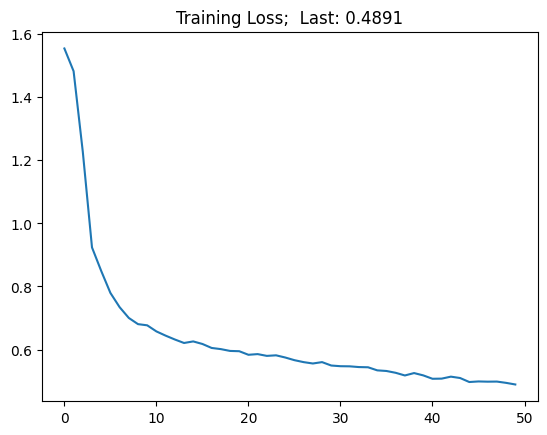

In [16]:
EPOCHS = 50
BS = 32
X_train, Y_train, X_test, Y_test = get_dataset(window=12, vars=list(cluster_dist.columns), split_ratio=0.9)

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BS, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test,  Y_test),  batch_size=64, shuffle=False)

model = ONI2ClustersGRU(input_size=31).to(device)
criterion = nn.KLDivLoss(reduction="batchmean") 
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

model.train()
loss_list = []

for t in tqdm(range(EPOCHS)): 
    cur_epoch_loss = []
    for batch, (xb, yb) in enumerate(train_loader):
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = criterion(pred, yb)

        # Retropropagação
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        cur_epoch_loss.append(loss.item())
        
    loss_list.append(np.average(cur_epoch_loss))

plt.plot(loss_list)
plt.title(f'Training Loss;  Last: {loss_list[-1]:.4f}')

model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds.append(model(xb).exp().cpu().numpy())
        trues.append(yb.cpu().numpy())
P = np.vstack(preds)   
Q = np.vstack(trues)   
print("Mean JS divergence:", js_divergence(P, Q).mean())

mae_per_cluster = abs(P - Q).mean()*100
print(f"MAE per cluster: {mae_per_cluster:.4f}%")

<Axes: >

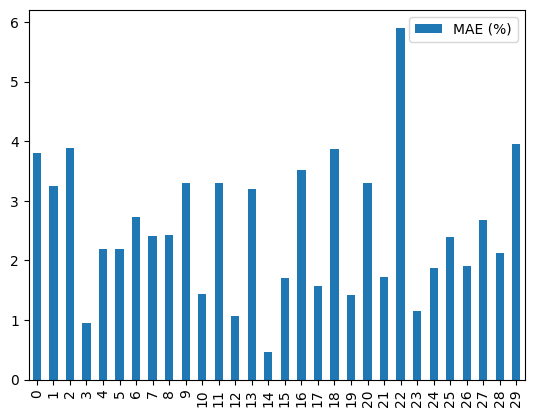

In [17]:
mae_per_cluster = abs(P - Q).mean(axis=0)*100
mae_df = pd.DataFrame({
    'MAE (%)': mae_per_cluster
})
mae_df.plot.bar()